# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Оглавление

1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропусков и замена типов данных](#null)
    * [Обработка наименования населенных пунктов](#name)
3. [Расчет новых параметоров](#new)
4. [Анализ данных](#analysis)
    * [По площади](#area)
    * [По цене](#price)
    * [По количеству комнат](#rooms)
    * [По высоте потолков](#ceiling)
    * [Общая матрица](#matrix)
    * [Время продажи](#time)
5. [Зависимость цены квартиры](#corr)
    * [От площади](#corr_area)
    * [От количества комнат](#corr_rooms)
    * [От этажа](#corr_floor)
    * [От удаленности от центра](#corr_center)
    * [От дня объявления](#corr_day)
6. [ТОП-10 городов по объявлениям](#top)
7. [Анализ центра города](#center)
    * [Определение границ](#km)
    * [Анализ показателей](#an)
    * [Вывод](#center_conclusion)
8. [Общий вывод](#conclusion)

<a id="start"></a>
## Шаг 1. Откройте файл с данными и изучите общую информацию.

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

In [5]:
kvartiri_spb = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [6]:
pd.options.display.max_columns = None

In [7]:
kvartiri_spb.info()
kvartiri_spb.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

Имеем входные данные длинной в 23699 строк с 22 параметрами (столбцами) описания объявлений по жилой недвижимости. Наименование столбцов в целом устраивает (корме cityCenters_nearest, который переименуем), много пустых ячеек в столбце is_apartment (тут все логично, их заполним). Мало данных по высоте потолков - не многие, похоже, знают высоту над уровнем головы - с этим придется повозиться. И могут быть по-разному записаны одни и те же города в столбце locality_name. Что касается типов данных, то в этот раз к вещественным и числовымдобавились еще и булевые, и при выводе данных еще видим и временнЫе (с датой) - надо будет их преобразовать. 

<a id="preprocessing"></a>
## Шаг 2. Предобработка данных

Для нормальной работы с данными, приведем их в порядок.  
Начнем с удаления дубликатов и переименования столбца для исключения прописных букв и сцепленных пробелов. И "is" в наименовании столбца про апартаменты мне тоже кажется лишним...

In [8]:
kvartiri_spb.duplicated().sum()

0

In [9]:
kvartiri_spb.columns = ['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']
kvartiri_spb.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

<a id="null"></a>
### Обработка пропусков

Продолжим с пропусками. Разберемся с теми, где понятно. Пропуски в стобцах is_apartment, parks_around3000, ponds_around3000 очевидно означают, что в объевлении не апартаменты, нет рядом парков и нет рядом прудов, соответственно. 

In [10]:
kvartiri_spb['apartment'].unique()
#kvartiri_spb[kvartiri_spb['is_apartment'].isnull()]

array([nan, False, True], dtype=object)

У нас тут похоже булевый столбец. И хотя у нас нет косвенных данных, по которым мы можем проверить действительно ли пропущенные позиции являются апратаментами, так как доля имеющихся True апартаментов 2775 из 23699 (чуть больше 10 %) как раз соответстветствует примерному количеству апартаментов на рынке недвижимости в Питере*, мы смело можем утверждать, что эти пропуски самые что ни на есть жилые помещения. Заменим их на False и превратим тип в булевой.  
*Данные взяты вот тут https://www.novostroy-spb.ru/novosti/apartamenty_zanyali_desyatuyu_chast

In [11]:
kvartiri_spb['apartment'] = kvartiri_spb['apartment'].fillna('False').astype('bool')

С этим столбцом разобрались. Пустые значения могли возникнуть из-за неправильного заполнения формы пользователями, если там надо было выбирать параметр, или сбоя выгрузки данных.

Перейдем к паркам и прудам. Проверим нет ли случаем, когда данные в количестве отсутствуют, а расстояние до ближайшего указана. 

In [12]:
kvartiri_spb[(kvartiri_spb['parks_around3000'].isnull() == True)
             & (kvartiri_spb['parks_nearest'].isnull() == False)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [13]:
kvartiri_spb[(kvartiri_spb['ponds_around3000'].isnull() == True)
             & (kvartiri_spb['ponds_nearest'].isnull() == False)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Тогда заполним пропуски нулями. И приведем их к целочисленному значению, так как это штучные элементы. Видимо, тоже сбой или при заполнении, или при выгрузке.

In [14]:
kvartiri_spb['parks_around3000'] = kvartiri_spb['parks_around3000'].fillna(0).astype('int')
kvartiri_spb['ponds_around3000'] = kvartiri_spb['ponds_around3000'].fillna(0).astype('int')
kvartiri_spb.info()
kvartiri_spb.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
apartment               23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
city_centers_nearest    18180 non-null float64
parks_around3000        23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around3000  

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,True,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,True,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,True,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,True,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,True,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,True,False,False,9.1,NaN,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0


То же сделаем и с балконами

In [15]:
kvartiri_spb['balcony'] = kvartiri_spb['balcony'].fillna(0).astype('int')
kvartiri_spb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
apartment               23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
city_centers_nearest    18180 non-null float64
parks_around3000        23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around3000    

Обратим внимание на пропуски в категориальных переменных, то есть в столбце locality_name. 

In [16]:
kvartiri_spb[kvartiri_spb['locality_name'].isnull()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.80,2,True,False,False,8.80,0,NaN,23478.0,4258.0,0,NaN,0,NaN,147.0
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,NaN,4.0,42.60,2,True,False,False,18.60,0,NaN,NaN,NaN,0,NaN,0,NaN,34.0
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,NaN,24.0,15.60,3,True,False,False,10.70,0,NaN,22041.0,17369.0,0,NaN,1,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,NaN,24.0,33.10,21,True,False,False,8.20,0,NaN,22041.0,17369.0,0,NaN,1,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,NaN,5.0,30.80,5,True,False,False,6.50,0,NaN,27419.0,8127.0,0,NaN,1,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.62,7,True,False,False,13.38,0,NaN,25054.0,3902.0,1,485.0,3,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.30,3,False,False,False,10.40,0,NaN,21774.0,3039.0,1,690.0,1,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,NaN,7.0,NaN,6,True,False,False,NaN,0,NaN,26534.0,5382.0,1,446.0,1,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,NaN,7.0,59.10,5,False,False,False,8.30,4,NaN,10556.0,9538.0,1,67.0,0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,NaN,24.0,20.00,23,True,False,False,NaN,0,NaN,21460.0,16788.0,0,NaN,1,170.0,49.0


<a id="name"></a>
Возможно, нам удастся сгруппировать данные так, чтобы по удаленнсоти от центра и аэропорта мы смогли определить населенный пункт. Но прежде нам надо разобраться с наименования в самом столбце населенных пунктов, чтобы нам возможно было их группировать.

In [17]:
kvartiri_spb['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

У нас по многим позициям отсутвует наименование типа населенного пункта, а сам населенный пункт всегда с заглавнной буквы, поэтому мы можем отбросить такие дубликаты, как 'поселок Гаврилово' - 'деревня Гарболово', которые отличаются только типом населенного пункта. Такие разночтения возникли, по-видимости, из-за незнания заполняющих объявления клиентов. Создадим регулярное выражение, которое будет выявлять все слова, начинающиеся со строчных букв и пробелы после них. Потом создадим функцию, заменяющую такие части на пустоту и применим эту функицю к нашему столбцу, создав новый столбец с упрощенными названиями.

In [18]:
import re

def del_lowercase_words(column):
    if pd.isna(column) == False:
        return re.sub(r'\b[а-я]\w+\s+', '', column)

kvartiri_spb['locality_simple_name'] = kvartiri_spb['locality_name'].apply(del_lowercase_words)
len(kvartiri_spb['locality_simple_name'].unique())
kvartiri_spb['locality_simple_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [19]:
kvartiri_spb.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'locality_simple_name'],
      dtype='object')

In [20]:
kvartiri_spb.pivot_table(index = 'locality_simple_name', 
                         values='city_centers_nearest', 
                         aggfunc=['min', 'max']
                        ).sort_values(by=('min', 'city_centers_nearest'))

,min,max
,city_centers_nearest,city_centers_nearest
locality_simple_name,,
Санкт-Петербург,181.0,29493.0
Шушары,17012.0,32079.0
Парголово,17994.0,24415.0
Стрельна,21813.0,24134.0
Мурино,21888.0,21888.0
Пушкин,24311.0,35610.0
Левашово,25727.0,25727.0
Песочный,25867.0,27835.0


Мы видим, что максимальное удаление от центра для Питера превышает расстояние до неокторых других населенных пунктов, но все, что меньше 17 тыс метров относится только к культурной столице, поэтому попробуем заполнить пропуски по этим данным.

In [21]:
kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'].isna()) 
                 & (kvartiri_spb['city_centers_nearest'] < 17000), 
                 'locality_simple_name'] = 'Санкт-Петербург'


Займемся пропусками с потолками. Отдельно заполним для Питера и отдельно для других, так как по специфики архитектуры в Питере средние показатели могут отличаться.

In [22]:
kvartiri_spb['floors_total'] = kvartiri_spb['floors_total'].fillna(kvartiri_spb['floor'])

In [23]:
kvartiri_spb['floors_total'] = kvartiri_spb['floors_total'].astype('int')

In [24]:
kvartiri_spb.pivot_table(index=['locality_simple_name', 'floors_total'],
                         values=['ceiling_height'],
                         aggfunc=['min', 'max', 'median', 'count']).loc['Санкт-Петербург']

,min,max,median,count
,ceiling_height,ceiling_height,ceiling_height,ceiling_height
floors_total,,,,
1,2.50,2.50,2.50,1
2,2.50,4.00,3.00,32
3,2.50,5.30,3.00,147
4,2.50,27.00,3.00,459
5,2.00,100.00,2.60,2042
6,2.40,32.00,3.15,499
7,2.45,6.00,3.00,339
8,2.49,5.20,3.00,160


Просмотрев сводные данные по Питеру можем сделать вывод, что выделяются 5-ти и 9-ти этажки (около 2.6 м), все что выше 2.7, остальное - 3 м.

In [25]:
kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'] == 'Санкт-Петербург')
                 & (kvartiri_spb['ceiling_height'].isna())
                 & ((kvartiri_spb['floors_total'] == 5)|(kvartiri_spb['floors_total'] == 9)),
                 'ceiling_height'] = kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'] == 'Санкт-Петербург')
                                                      & (kvartiri_spb['floors_total'] == 5 | 9),
                                                      'ceiling_height'].median()

In [26]:
kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'] == 'Санкт-Петербург')
                 & (kvartiri_spb['ceiling_height'].isna())
                 & (kvartiri_spb['floors_total'] > 9),
                 'ceiling_height'] = kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'] == 'Санкт-Петербург')
                                                      & (kvartiri_spb['floors_total'] > 9),
                                                      'ceiling_height'].median()

In [27]:
kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'] == 'Санкт-Петербург')
                 & (kvartiri_spb['ceiling_height'].isna())
                 & (kvartiri_spb['floors_total'] < 9)
                 & (kvartiri_spb['floors_total'] != 5),
                 'ceiling_height'] = kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'] == 'Санкт-Петербург')
                                                      & (kvartiri_spb['floors_total'] < 9)
                                                      & (kvartiri_spb['floors_total'] != 5),
                                                      'ceiling_height'].median()

In [28]:
kvartiri_spb.loc[(kvartiri_spb['locality_simple_name'] == 'Санкт-Петербург')
                 & (kvartiri_spb['ceiling_height'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name


In [29]:
kvartiri_spb.query('ceiling_height.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11,18.60,1,True,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12,14.40,5,True,False,False,9.10,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,Янино-1
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26,10.60,6,True,False,False,14.40,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,Парголово
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27,15.43,26,True,False,False,8.81,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189.0,Мурино
11,9,3300000.0,44.00,2018-08-27T00:00:00,2,NaN,5,31.00,4,False,False,False,6.00,1,Ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0,Ломоносов
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23669,8,3000000.0,34.10,2017-11-10T00:00:00,1,NaN,9,17.00,3,True,False,False,9.00,1,Колпино,24687.0,30473.0,0,NaN,1,741.0,74.0,Колпино
23679,0,2500000.0,35.00,2017-12-08T00:00:00,1,NaN,9,NaN,4,True,False,False,NaN,0,Сосновый Бор,NaN,NaN,0,NaN,0,NaN,45.0,Сосновый Бор
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5,17.50,4,True,False,False,6.00,0,Тихвин,NaN,NaN,0,NaN,0,NaN,413.0,Тихвин
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5,38.00,4,True,False,False,8.50,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0,Тосно


По Питеру пропуски с высостой потолков заполнили, остается 3558 пропусков в других населенных пунктах. Здесть также сгруппируем по этажности и посмотрим на медиану и сопутсвующие показатели, чтобы принять решение, как заполнить пропуски.

In [30]:
kvartiri_spb.pivot_table(index=['floors_total'],
                         values=['ceiling_height'],
                         aggfunc=['min', 'max', 'median', 'count'])

,min,max,median,count
,ceiling_height,ceiling_height,ceiling_height,ceiling_height
floors_total,,,,
1,2.30,3.00,2.90,12
2,1.20,27.00,2.75,235
3,2.50,32.00,2.90,481
4,2.40,27.00,3.00,988
5,2.00,100.00,2.60,4669
6,2.40,32.00,3.00,848
7,2.45,6.00,3.00,561
8,2.40,5.20,3.00,357


Ситуация такая же, но попробуем теперь заполнить пропуски более изящным способом, использую группировку.   
Разбивать на более крупные группы я не буду, так как выбивающаяся медиана только в одном здании с 37 этажами.

In [31]:
#df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform('median'))
kvartiri_spb['ceiling_height'] = kvartiri_spb['ceiling_height'
                                             ].fillna(kvartiri_spb.groupby('floors_total'
                                                                          )['ceiling_height'].transform('median'))
kvartiri_spb.query('ceiling_height.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name


Думаю можно еще заполнить пропуски в жилой площади и площади кухни, опираясь на процент, который они занимают от общей площади.  
Группировать будем по количеству комнат и этатжности дома. 

Сначала добавим столбцы, высчитывающие долю жилой площади или кухни от общей.

In [32]:
kvartiri_spb['living_area_part'] = kvartiri_spb['living_area']/kvartiri_spb['total_area']
kvartiri_spb['kitchen_area_part'] = kvartiri_spb['kitchen_area']/kvartiri_spb['total_area']

Теперь заполним пропуски по этим данным

In [33]:
kvartiri_spb['living_area'] = kvartiri_spb['living_area'
                                             ].fillna(kvartiri_spb.groupby('rooms'
                                                                          )['living_area_part'
                                                                           ].transform('median'
                                                                                      )*kvartiri_spb['total_area'])

In [34]:
kvartiri_spb['kitchen_area'] = kvartiri_spb['kitchen_area'
                                             ].fillna(kvartiri_spb.groupby('rooms'
                                                                          )['kitchen_area_part'].transform('median')*kvartiri_spb['total_area'])

In [35]:
kvartiri_spb.query('living_area.isna() or kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.7,24,15.500000,2,True,True,False,NaN,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,181.0,Мурино,0.574074,NaN
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.7,14,17.000000,1,True,False,True,NaN,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45.0,Кудрово,0.680000,NaN
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.7,17,24.750000,4,True,True,False,NaN,2,Санкт-Петербург,38171.0,15015.0,0,NaN,2,982.0,64.0,Санкт-Петербург,0.912947,NaN
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.7,26,24.300000,19,True,False,True,NaN,1,посёлок Парголово,53115.0,19292.0,0,NaN,1,593.0,430.0,Парголово,0.706395,NaN
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.7,10,17.241379,7,True,True,False,NaN,0,посёлок Шушары,NaN,NaN,0,NaN,0,NaN,29.0,Шушары,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,2.7,25,18.000000,16,True,True,False,NaN,0,Санкт-Петербург,11405.0,13222.0,0,NaN,1,623.0,14.0,Санкт-Петербург,0.692308,NaN
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,2.7,24,18.000000,4,True,False,True,NaN,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,4.0,Мурино,0.649819,NaN
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,2.7,19,17.931034,8,True,True,False,NaN,0,Санкт-Петербург,18090.0,17092.0,0,NaN,2,112.0,31.0,Санкт-Петербург,NaN,NaN
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,2.6,9,18.000000,8,True,False,True,NaN,2,Никольское,NaN,NaN,0,NaN,0,NaN,82.0,Никольское,0.620690,NaN


После группировки по комнатам у нас остались незаполненные пропуски. Теперь сгруппируем по этажности домов для заполнения оставшихся 197 позиций

In [36]:
kvartiri_spb['living_area'] = kvartiri_spb['living_area'
                                             ].fillna(kvartiri_spb.groupby('floors_total'
                                                                          )['living_area_part'].transform('median')*kvartiri_spb['total_area'])

In [37]:
kvartiri_spb['kitchen_area'] = kvartiri_spb['kitchen_area'
                                             ].fillna(kvartiri_spb.groupby('floors_total'
                                                                          )['kitchen_area_part'].transform('median')*kvartiri_spb['total_area'])

In [38]:
kvartiri_spb.query('living_area.isna() or kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part


In [39]:
kvartiri_spb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
apartment               23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
city_centers_nearest    18180 non-null float64
parks_around3000        23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around3000      

И напоследок переведем столбец с ценой в целочисленные значения, так как копейки в данных обстоятельствах нас не интересуют

In [40]:
kvartiri_spb['last_price'] = kvartiri_spb['last_price'].astype('int')

<a id="new"></a>
## Шаг 3. Посчитайте и добавьте в таблицу

Посчитаем и добавим в таблицу цену квадратного метра

In [41]:
kvartiri_spb['last_price'].agg(['min','max','mean','median'])

min       1.219000e+04
max       7.630000e+08
mean      6.541549e+06
median    4.650000e+06
Name: last_price, dtype: float64

Что-то не так с максимальными ценами... Но вернемся к этому позже

In [42]:
kvartiri_spb['total_area'].agg(['min','max','mean','median'])

min        12.000000
max       900.000000
mean       60.348651
median     52.000000
Name: total_area, dtype: float64

In [43]:
kvartiri_spb['m2_price'] = kvartiri_spb['last_price'] / kvartiri_spb['total_area']
kvartiri_spb['m2_price'] = kvartiri_spb['m2_price'].astype('int')

Приведем в порядок столбец с датой и временем публикации

In [44]:
kvartiri_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,0.472222,0.231481,120370
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.70,11,18.600,1,True,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,0.460396,0.272277,82920
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.70,5,34.300,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,0.612500,0.148214,92785
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.70,14,100.435,9,True,False,False,20.442857,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург,NaN,NaN,408176
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,0.320000,0.410000,100000


In [45]:
pd.to_datetime(kvartiri_spb['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

Посчитаем день недели, месяц и год пубикации

In [46]:
kvartiri_spb['expositions_weekday'] = pd.DatetimeIndex(kvartiri_spb['first_day_exposition']).weekday

In [47]:
kvartiri_spb['expositions_month'] = pd.DatetimeIndex(kvartiri_spb['first_day_exposition']).month

In [48]:
kvartiri_spb['expositions_year'] = pd.DatetimeIndex(kvartiri_spb['first_day_exposition']).year

In [49]:
kvartiri_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,0.472222,0.231481,120370,3,3,2019
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.70,11,18.600,1,True,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,0.460396,0.272277,82920,1,12,2018
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.70,5,34.300,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,0.612500,0.148214,92785,3,8,2015
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.70,14,100.435,9,True,False,False,20.442857,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург,NaN,NaN,408176,4,7,2015
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,0.320000,0.410000,100000,1,6,2018


In [50]:
kvartiri_spb['expositions_weekday'].unique()

array([3, 1, 4, 0, 2, 6, 5])

In [51]:
def weekday_recognizer(data):
    if data['expositions_weekday'] == 0:
        return 'понедельник'
    elif data['expositions_weekday'] == 1:
        return 'вторник'
    elif data['expositions_weekday'] == 2:
        return 'среда'
    elif data['expositions_weekday'] == 3:
        return 'четверг'
    elif data['expositions_weekday'] == 4:
        return 'пятница'
    elif data['expositions_weekday'] == 5:
        return 'суббота'
    elif data['expositions_weekday'] == 6:
        return 'воскресенье'

In [52]:
kvartiri_spb['expositions_weekday'] = kvartiri_spb.apply(weekday_recognizer, axis=1)

In [53]:
kvartiri_spb['expositions_weekday'].unique()

array(['четверг', 'вторник', 'пятница', 'понедельник', 'среда',
       'воскресенье', 'суббота'], dtype=object)

In [54]:
kvartiri_spb['expositions_month'].unique()

array([ 3, 12,  8,  7,  6,  9, 11,  4,  5,  2,  1, 10])

In [55]:
def month_recognizer(data):
    if data['expositions_month'] == 1:
        return 'январь'
    elif data['expositions_month'] == 2:
        return 'февраль'
    elif data['expositions_month'] == 3:
        return 'март'
    elif data['expositions_month'] == 4:
        return 'апрель'
    elif data['expositions_month'] == 5:
        return 'май'
    elif data['expositions_month'] == 6:
        return 'июнь'
    elif data['expositions_month'] == 7:
        return 'июль'
    elif data['expositions_month'] == 8:
        return 'август'
    elif data['expositions_month'] == 9:
        return 'сентябрь'
    elif data['expositions_month'] == 10:
        return 'октябрь'
    elif data['expositions_month'] == 11:
        return 'ноябрь'
    elif data['expositions_month'] == 12:
        return 'декабрь'

In [56]:
kvartiri_spb['expositions_month'] = kvartiri_spb.apply(month_recognizer, axis=1)

In [57]:
kvartiri_spb['expositions_month'].unique()

array(['март', 'декабрь', 'август', 'июль', 'июнь', 'сентябрь', 'ноябрь',
       'апрель', 'май', 'февраль', 'январь', 'октябрь'], dtype=object)

Теперь напишем функицю для определения этажа и применим её для создания нового столбца с отнесением этажа к первому, последнему или другому.

In [58]:
def floor_definition(data):
    if data['floor'] == 1:
        return 'первый'
    elif (data['floors_total'] == data['floor']) & (data['floor'] != 1):
        return 'последний'
    else:
        return 'другой'

In [59]:
kvartiri_spb['whats_floor'] = kvartiri_spb.apply(floor_definition, axis = 1)

In [60]:
kvartiri_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,0.472222,0.231481,120370,четверг,март,2019,другой
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.70,11,18.600,1,True,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,0.460396,0.272277,82920,вторник,декабрь,2018,первый
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.70,5,34.300,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,0.612500,0.148214,92785,четверг,август,2015,другой
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.70,14,100.435,9,True,False,False,20.442857,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург,NaN,NaN,408176,пятница,июль,2015,другой
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,0.320000,0.410000,100000,вторник,июнь,2018,другой


<a id="analysis"></a>
## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Детальней изучим следующие параметры: площадь, цена, число комнат, высота потолков.   
Построим графики, диаграммы и ящики с усами

<a id="area"></a>
### По площади

In [61]:
kvartiri_spb['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

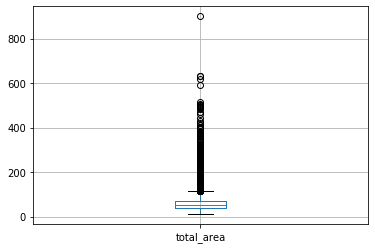

In [62]:
kvartiri_spb.boxplot(column='total_area');

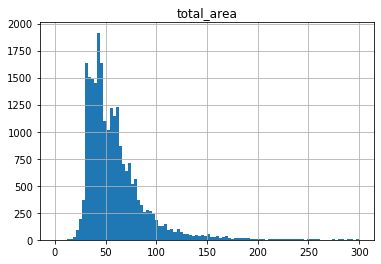

In [63]:
kvartiri_spb.hist(bins=100, range=(0, 300), column='total_area');

По площади, на мой взгляд, распределение приемлимое. Минимальное значание реальное, 12 м2 может быть комнатой, которую выставили на продажу. Медиана 52 м2, основная часть объявлений в границах 30-80 м2 и незначительное количество крупноплощадочных объектов после 150 м2 тоже вполне может быть реальным, если это частные дома или квартиры в несколько этажей. Можем посмотреть на них отдельно. Выбивается только сильно одно объявление и мне кажется стандартное отклонение слишком большим...

In [64]:
kvartiri_spb.query('total_area > 450').sort_values(by='total_area', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
19540,8,420000000,900.0,2017-12-06T00:00:00,12,2.80,25,409.700000,25,True,False,False,112.000000,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0,Санкт-Петербург,0.455222,0.124444,466666,среда,декабрь,2017,последний
12859,20,140000000,631.2,2019-04-09T00:00:00,7,3.90,4,322.300000,4,True,False,False,19.500000,1,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,NaN,Санкт-Петербург,0.510615,0.030894,221799,вторник,апрель,2019,последний
3117,19,140000000,631.0,2019-03-30T00:00:00,7,2.70,5,430.133948,5,True,False,False,60.000000,0,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,NaN,Санкт-Петербург,NaN,0.095087,221870,суббота,март,2019,последний
15651,20,300000000,618.0,2017-12-18T00:00:00,7,3.40,7,258.000000,5,True,False,False,70.000000,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111.0,Санкт-Петербург,0.417476,0.113269,485436,понедельник,декабрь,2017,другой
5358,20,65000000,590.0,2019-02-14T00:00:00,15,3.50,6,409.000000,3,True,False,False,100.000000,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14.0,Санкт-Петербург,0.693220,0.169492,110169,четверг,февраль,2019,другой
4237,1,50000000,517.0,2017-10-14T00:00:00,7,3.00,4,332.000000,3,True,False,False,22.000000,0,Санкт-Петербург,22835.0,1847.0,2,477.0,2,540.0,NaN,Санкт-Петербург,0.642166,0.042553,96711,суббота,октябрь,2017,другой
8018,20,84000000,507.0,2015-12-17T00:00:00,5,4.45,7,301.500000,7,True,False,False,45.500000,1,Санкт-Петербург,NaN,5735.0,2,110.0,0,NaN,1078.0,Санкт-Петербург,0.594675,0.089744,165680,четверг,декабрь,2015,последний
5893,3,230000000,500.0,2017-05-31T00:00:00,6,3.00,7,339.705882,7,True,False,False,40.000000,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,50.0,Санкт-Петербург,NaN,0.080000,460000,среда,май,2017,последний
15016,8,150000000,500.0,2016-01-13T00:00:00,4,3.20,7,329.870130,7,True,False,False,56.122449,0,Санкт-Петербург,33058.0,6150.0,3,209.0,3,531.0,303.0,Санкт-Петербург,NaN,NaN,300000,среда,январь,2016,последний
12401,20,91500000,495.0,2017-06-19T00:00:00,7,4.65,7,347.500000,7,True,False,False,25.000000,0,Санкт-Петербург,NaN,5735.0,2,110.0,0,NaN,14.0,Санкт-Петербург,0.702020,0.050505,184848,понедельник,июнь,2017,последний


Эти объявления со сверхвысокими значениями в площади вполне могут быть реальны и не вызывают каких-то явных противоречий, поэтому оставим их. Их значение влияют на среднее, однако лучше сохранить их и пользоваться медианой.

<a id="price"></a>
### Посмотрим на стоимости

In [65]:
kvartiri_spb['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

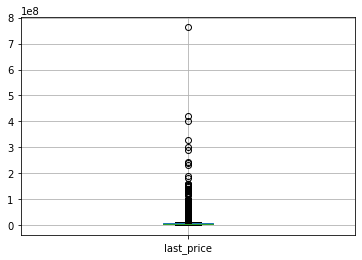

In [66]:
kvartiri_spb.boxplot(column='last_price');

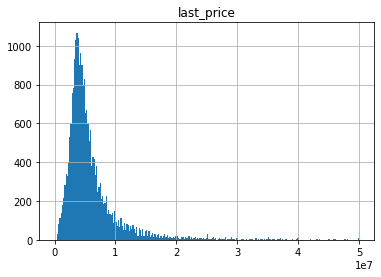

In [67]:
kvartiri_spb.hist(bins=250, range=(0, 50000000), column='last_price');

In [68]:
kvartiri_spb.query('last_price > 2*10**8').sort_values(by='last_price', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
12971,19,763000000,400.0,2017-09-30T00:00:00,7,2.70,10,250.000000,10,True,False,False,33.486994,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33.0,Санкт-Петербург,0.625000,NaN,1907500,суббота,сентябрь,2017,последний
19540,8,420000000,900.0,2017-12-06T00:00:00,12,2.80,25,409.700000,25,True,False,False,112.000000,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0,Санкт-Петербург,0.455222,0.124444,466666,среда,декабрь,2017,последний
14706,15,401300000,401.0,2016-02-20T00:00:00,5,2.70,9,204.000000,9,False,False,False,24.000000,3,Санкт-Петербург,21912.0,2389.0,1,545.0,1,478.0,393.0,Санкт-Петербург,0.508728,0.059850,1000748,суббота,февраль,2016,последний
1436,19,330000000,190.0,2018-04-04T00:00:00,3,3.50,7,95.000000,5,True,False,False,40.000000,0,Санкт-Петербург,23011.0,1197.0,3,519.0,3,285.0,233.0,Санкт-Петербург,0.500000,0.210526,1736842,среда,апрель,2018,другой
15651,20,300000000,618.0,2017-12-18T00:00:00,7,3.40,7,258.000000,5,True,False,False,70.000000,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111.0,Санкт-Петербург,0.417476,0.113269,485436,понедельник,декабрь,2017,другой
22831,18,289238400,187.5,2019-03-19T00:00:00,2,3.37,6,63.700000,6,True,False,False,30.200000,0,Санкт-Петербург,22494.0,1073.0,3,386.0,3,188.0,NaN,Санкт-Петербург,0.339733,0.161067,1542604,вторник,март,2019,последний
16461,17,245000000,285.7,2017-04-10T00:00:00,6,3.35,7,182.800000,4,True,False,False,29.800000,0,Санкт-Петербург,33143.0,6235.0,3,400.0,3,140.0,249.0,Санкт-Петербург,0.639832,0.104305,857542,понедельник,апрель,2017,другой
13749,7,240000000,410.0,2017-04-01T00:00:00,6,3.40,7,218.000000,7,True,False,False,40.000000,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,199.0,Санкт-Петербург,0.531707,0.097561,585365,суббота,апрель,2017,последний
5893,3,230000000,500.0,2017-05-31T00:00:00,6,3.00,7,339.705882,7,True,False,False,40.000000,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,50.0,Санкт-Петербург,NaN,0.080000,460000,среда,май,2017,последний


В целом наблюдаем нормальное распределение, но опять сильно выбивается одно объявление, причем не то, что было по площади. Скорее всего их лучше будет отбросить. Основная часть объявлений находится в рамках 3,5 - 7 млн руб, после 10 млн количество объявлений сильно снижается.

<a id="rooms"></a>
### Теперь взглянем на распределение по количеству комнат.

In [69]:
kvartiri_spb['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

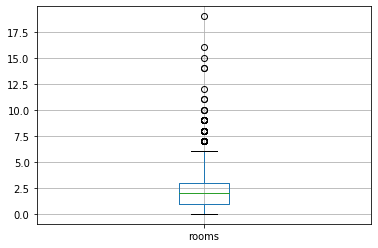

In [70]:
kvartiri_spb.boxplot(column='rooms');

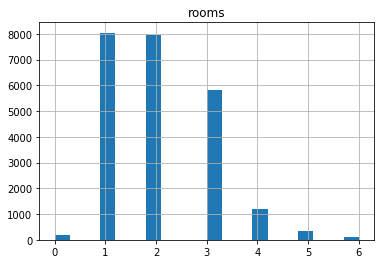

In [71]:
kvartiri_spb.hist(bins=20, range=(0, 6), column='rooms');

In [72]:
kvartiri_spb.query('rooms > 7').sort_values(by='rooms', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
14498,6,32250000,374.6,2018-06-09T00:00:00,19,2.70,5,264.500000,2,True,False,False,27.600000,0,Санкт-Петербург,19497.0,3574.0,0,NaN,2,548.0,114.0,Санкт-Петербург,0.706086,0.073679,86091,суббота,июнь,2018,другой
18848,6,28500000,270.0,2015-03-02T00:00:00,16,3.00,4,180.000000,4,True,False,False,13.000000,1,Санкт-Петербург,23575.0,4142.0,1,516.0,0,NaN,1365.0,Санкт-Петербург,0.666667,0.048148,105555,понедельник,март,2015,последний
5358,20,65000000,590.0,2019-02-14T00:00:00,15,3.50,6,409.000000,3,True,False,False,100.000000,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14.0,Санкт-Петербург,0.693220,0.169492,110169,четверг,февраль,2019,другой
866,5,25000000,363.0,2017-12-23T00:00:00,14,3.16,5,222.000000,4,True,False,False,16.600000,0,Санкт-Петербург,38076.0,7950.0,0,NaN,2,435.0,418.0,Санкт-Петербург,0.611570,0.045730,68870,суббота,декабрь,2017,другой
20829,6,28659000,245.4,2016-03-31T00:00:00,14,3.00,4,168.300000,2,True,False,False,25.900000,0,Санкт-Петербург,21104.0,2054.0,3,541.0,2,118.0,95.0,Санкт-Петербург,0.685819,0.105542,116784,четверг,март,2016,другой
19540,8,420000000,900.0,2017-12-06T00:00:00,12,2.80,25,409.700000,25,True,False,False,112.000000,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0,Санкт-Петербург,0.455222,0.124444,466666,среда,декабрь,2017,последний
648,3,17500000,183.7,2018-07-01T00:00:00,11,3.40,7,138.800000,7,True,False,False,13.300000,0,Санкт-Петербург,23606.0,3148.0,0,NaN,0,NaN,NaN,Санкт-Петербург,0.755580,0.072401,95264,воскресенье,июль,2018,последний
9688,8,33000000,194.1,2017-02-07T00:00:00,11,3.43,5,129.000000,2,True,False,False,11.900000,0,Санкт-Петербург,21469.0,1015.0,1,686.0,2,66.0,813.0,Санкт-Петербург,0.664606,0.061309,170015,вторник,февраль,2017,другой
4149,6,23000000,272.6,2018-01-11T00:00:00,10,3.14,7,145.900000,7,True,False,False,18.800000,1,Санкт-Петербург,10726.0,12169.0,1,191.0,1,531.0,NaN,Санкт-Петербург,0.535216,0.068966,84372,четверг,январь,2018,последний
18891,11,40000000,290.0,2016-06-21T00:00:00,10,3.50,6,189.400000,6,True,False,False,30.000000,1,Санкт-Петербург,26229.0,4932.0,3,316.0,1,227.0,77.0,Санкт-Петербург,0.653103,0.103448,137931,вторник,июнь,2016,последний


Кваритиры с 19 комнатами я еще могу представить, но вот с 0 комнат, как-то тяжело... Это упущение нужно исправить. Посмотрим на них и заменим на 1 комнату, если это просто такая интерпритация студий или чего-то подобного

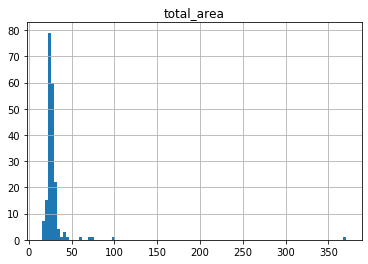

In [73]:
kvartiri_spb.query('rooms == 0').hist(column='total_area', bins=100);

In [74]:
kvartiri_spb[kvartiri_spb['rooms'] == 0].sort_values(by='total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
8886,10,2450000,15.5,2018-08-22T00:00:00,0,2.70,5,10.000000,2,True,True,False,2.230216,0,Санкт-Петербург,24326.0,4589.0,0,NaN,1,446.0,27.0,Санкт-Петербург,0.645161,NaN,158064,среда,август,2018,другой
9412,5,2100000,16.0,2017-12-10T00:00:00,0,3.00,6,13.000000,1,True,False,True,2.533135,0,Санкт-Петербург,20735.0,2111.0,2,228.0,3,72.0,3.0,Санкт-Петербург,0.812500,NaN,131250,воскресенье,декабрь,2017,первый
716,5,1500000,17.0,2017-06-07T00:00:00,0,2.70,9,12.000000,1,True,True,False,2.626364,0,посёлок Шушары,18654.0,29846.0,0,NaN,0,NaN,40.0,Шушары,0.705882,NaN,88235,среда,июнь,2017,первый
12996,8,1900000,18.0,2019-01-25T00:00:00,0,2.60,5,16.000000,3,True,True,False,2.589928,0,Санкт-Петербург,19573.0,15772.0,2,149.0,2,496.0,10.0,Санкт-Петербург,0.888889,NaN,105555,пятница,январь,2019,другой
8755,1,1350000,18.8,2017-11-22T00:00:00,0,2.75,19,15.800000,1,True,True,False,4.106566,0,Санкт-Петербург,37636.0,14479.0,0,NaN,1,1127.0,128.0,Санкт-Петербург,0.840426,NaN,71808,среда,ноябрь,2017,первый
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13613,16,8100000,58.4,2019-04-26T00:00:00,0,3.30,7,33.000000,6,True,True,False,9.102627,0,Санкт-Петербург,14509.0,8288.0,0,NaN,0,NaN,NaN,Санкт-Петербург,0.565068,NaN,138698,пятница,апрель,2019,другой
21227,0,8200000,71.0,2017-07-21T00:00:00,0,5.80,5,68.000000,5,True,True,False,10.215827,0,Санкт-Петербург,20170.0,1261.0,2,295.0,3,366.0,30.0,Санкт-Петербург,0.957746,NaN,115492,пятница,июль,2017,последний
3458,6,7400000,73.6,2017-05-18T00:00:00,0,3.00,3,50.000000,1,True,True,False,11.225559,0,Санкт-Петербург,26581.0,6085.0,0,NaN,1,348.0,60.0,Санкт-Петербург,0.679348,NaN,100543,четверг,май,2017,первый
20082,10,16300000,98.4,2017-11-08T00:00:00,0,3.10,5,60.500000,2,True,True,False,14.158273,0,Санкт-Петербург,26972.0,5819.0,0,NaN,1,674.0,537.0,Санкт-Петербург,0.614837,NaN,165650,среда,ноябрь,2017,другой


In [75]:
kvartiri_spb.loc[kvartiri_spb['rooms'] == 0, 'rooms'] = 1

В количестве комнат преобладает 1 и 2ух комнатные квартиры примерно наравне, чуть реже встречаются 3ех комнатные и совсем редко 4-ех. Однако есть и многокомнантные, да такие из которых можно делать полноценные гостиницы...

<a id="ceiling"></a>
### Перейдем к потолкам

In [76]:
kvartiri_spb['ceiling_height'].describe()

count    23699.000000
mean         2.754737
std          0.989399
min          1.000000
25%          2.600000
50%          2.700000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

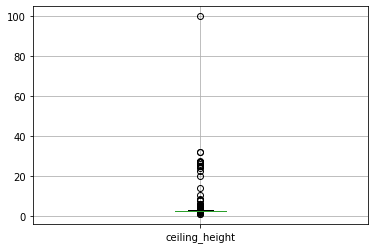

In [77]:
kvartiri_spb.boxplot(column='ceiling_height');

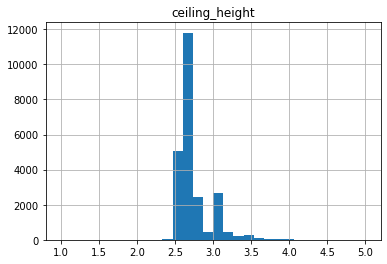

In [78]:
kvartiri_spb.hist(bins=30, range=(1, 5), column='ceiling_height');

In [79]:
kvartiri_spb.query('ceiling_height > 40').sort_values(by='ceiling_height', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
22869,0,15000000,25.0,2018-07-25T00:00:00,1,100.0,5,14.0,5,True,False,False,11.0,5,Санкт-Петербург,34963.0,8283.0,1,223.0,3,30.0,19.0,Санкт-Петербург,0.56,0.44,600000,среда,июль,2018,последний


Boxplot показывает нам странное скопление в промежутке между 15 и 40 м. Думаю это ошибка в 10ых. Посмотрим на них и исправим ошибку

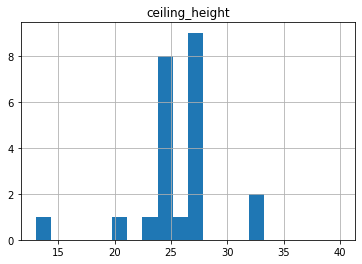

In [80]:
kvartiri_spb.hist(bins=20, range=(13, 40), column='ceiling_height');

In [81]:
kvartiri_spb.query('13 < ceiling_height < 40').sort_values(by='ceiling_height', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
22336,19,9999000,92.4,2019-04-05T00:00:00,2,32.0,6,55.5,5,False,False,False,16.500000,4,Санкт-Петербург,18838.0,3506.0,0,NaN,3,511.0,NaN,Санкт-Петербург,0.600649,0.178571,108214,пятница,апрель,2019,другой
3148,14,2900000,75.0,2018-11-12T00:00:00,3,32.0,3,53.0,2,True,False,False,8.000000,0,Волхов,NaN,NaN,0,NaN,0,NaN,NaN,Волхов,0.706667,0.106667,38666,понедельник,ноябрь,2018,другой
21377,19,4900000,42.0,2017-04-18T00:00:00,1,27.5,24,37.7,19,False,False,False,11.000000,2,Санкт-Петербург,42742.0,9760.0,0,NaN,0,NaN,61.0,Санкт-Петербург,0.897619,0.261905,116666,вторник,апрель,2017,другой
22938,14,4000000,98.0,2018-03-15T00:00:00,4,27.0,2,73.0,2,True,False,False,9.000000,1,деревня Нижняя,NaN,NaN,0,NaN,0,NaN,27.0,Нижняя,0.744898,0.091837,40816,четверг,март,2018,последний
17857,1,3900000,56.0,2017-12-22T00:00:00,3,27.0,5,33.0,4,False,False,False,7.200000,0,Санкт-Петербург,41030.0,15543.0,0,NaN,0,NaN,73.0,Санкт-Петербург,0.589286,NaN,69642,пятница,декабрь,2017,другой
4876,7,3000000,25.0,2017-09-27T00:00:00,1,27.0,25,17.0,17,True,False,True,5.654762,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,28.0,Мурино,0.680000,NaN,120000,среда,сентябрь,2017,другой
21824,20,2450000,44.0,2019-02-12T00:00:00,2,27.0,2,38.0,2,False,False,False,8.600000,2,городской поселок Большая Ижора,NaN,NaN,0,NaN,0,NaN,NaN,Большая Ижора,0.863636,0.195455,55681,вторник,февраль,2019,последний
5246,0,2500000,54.0,2017-10-13T00:00:00,2,27.0,5,30.0,3,True,False,False,9.000000,2,деревня Мины,NaN,NaN,0,NaN,0,NaN,540.0,Мины,0.555556,0.166667,46296,пятница,октябрь,2017,другой
5807,17,8150000,80.0,2019-01-09T00:00:00,2,27.0,36,41.0,13,True,False,False,12.000000,5,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,38.0,Санкт-Петербург,0.512500,0.150000,101875,среда,январь,2019,другой
20478,11,8000000,45.0,2017-07-18T00:00:00,1,27.0,4,22.0,2,True,False,False,10.000000,1,Санкт-Петербург,18975.0,3246.0,0,NaN,3,449.0,429.0,Санкт-Петербург,0.488889,0.222222,177777,вторник,июль,2017,другой


In [82]:
kvartiri_spb.loc[(kvartiri_spb['ceiling_height'] > 13)&
                 (kvartiri_spb['ceiling_height'] < 40),
                 'ceiling_height'] = kvartiri_spb.loc[(kvartiri_spb['ceiling_height'] > 13)&
                                                      (kvartiri_spb['ceiling_height'] < 40),
                                                      'ceiling_height'] / 10

И уберем это объявление по продаже лифтовой шахты в высотке или что бы это ни было :)   
Наша статистика не пострадает от этого, а только станет лучше

In [83]:
kvartiri_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,0.472222,0.231481,120370,четверг,март,2019,другой
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.70,11,18.600,1,True,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,0.460396,0.272277,82920,вторник,декабрь,2018,первый
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.70,5,34.300,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,0.612500,0.148214,92785,четверг,август,2015,другой
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.70,14,100.435,9,True,False,False,20.442857,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург,NaN,NaN,408176,пятница,июль,2015,другой
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,0.320000,0.410000,100000,вторник,июнь,2018,другой


In [84]:
kvartiri_spb = kvartiri_spb.drop(kvartiri_spb[kvartiri_spb['ceiling_height'] > 60].index)
kvartiri_spb.reset_index()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
0,0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16,51.000000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,0.472222,0.231481,120370,четверг,март,2019,другой
1,1,7,3350000,40.40,2018-12-04T00:00:00,1,2.70,11,18.600000,1,True,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,0.460396,0.272277,82920,вторник,декабрь,2018,первый
2,2,10,5196000,56.00,2015-08-20T00:00:00,2,2.70,5,34.300000,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,0.612500,0.148214,92785,четверг,август,2015,другой
3,3,0,64900000,159.00,2015-07-24T00:00:00,3,2.70,14,100.435000,9,True,False,False,20.442857,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург,NaN,NaN,408176,пятница,июль,2015,другой
4,4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.000000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,0.320000,0.410000,100000,вторник,июнь,2018,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,23694,9,9700000,133.81,2017-03-21T00:00:00,3,3.70,5,73.300000,3,True,False,False,13.830000,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,Санкт-Петербург,0.547792,0.103356,72490,вторник,март,2017,другой
23694,23695,14,3100000,59.00,2018-01-15T00:00:00,3,2.60,5,38.000000,4,True,False,False,8.500000,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0,Тосно,0.644068,0.144068,52542,понедельник,январь,2018,другой
23695,23696,18,2500000,56.70,2018-02-11T00:00:00,2,2.90,3,29.700000,1,True,False,False,9.132958,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN,Рождествено,0.523810,NaN,44091,воскресенье,февраль,2018,первый
23696,23697,13,11475000,76.75,2017-03-28T00:00:00,2,3.00,17,44.899452,12,True,False,False,23.300000,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602.0,Санкт-Петербург,NaN,0.303583,149511,вторник,март,2017,другой


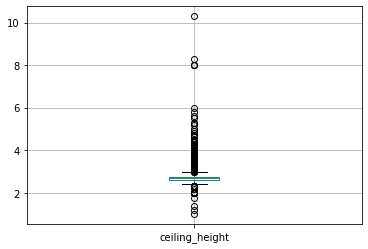

In [85]:
kvartiri_spb.boxplot(column='ceiling_height');

И я все-таки хочу избавиться от той сверхдорогой квартиры, а потом мы построим взаимозависящие графики и диаграммы.

In [86]:
kvartiri_spb.query('last_price > 5*10**8').sort_values(by='last_price', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
12971,19,763000000,400.0,2017-09-30T00:00:00,7,2.7,10,250.0,10,True,False,False,33.486994,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33.0,Санкт-Петербург,0.625,NaN,1907500,суббота,сентябрь,2017,последний


In [87]:
kvartiri_spb = kvartiri_spb.drop(kvartiri_spb[kvartiri_spb['last_price'] > 5*10**8].index)
kvartiri_spb.reset_index()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
0,0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16,51.000000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,0.472222,0.231481,120370,четверг,март,2019,другой
1,1,7,3350000,40.40,2018-12-04T00:00:00,1,2.70,11,18.600000,1,True,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,0.460396,0.272277,82920,вторник,декабрь,2018,первый
2,2,10,5196000,56.00,2015-08-20T00:00:00,2,2.70,5,34.300000,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,0.612500,0.148214,92785,четверг,август,2015,другой
3,3,0,64900000,159.00,2015-07-24T00:00:00,3,2.70,14,100.435000,9,True,False,False,20.442857,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург,NaN,NaN,408176,пятница,июль,2015,другой
4,4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.000000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,0.320000,0.410000,100000,вторник,июнь,2018,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,23694,9,9700000,133.81,2017-03-21T00:00:00,3,3.70,5,73.300000,3,True,False,False,13.830000,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,Санкт-Петербург,0.547792,0.103356,72490,вторник,март,2017,другой
23693,23695,14,3100000,59.00,2018-01-15T00:00:00,3,2.60,5,38.000000,4,True,False,False,8.500000,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0,Тосно,0.644068,0.144068,52542,понедельник,январь,2018,другой
23694,23696,18,2500000,56.70,2018-02-11T00:00:00,2,2.90,3,29.700000,1,True,False,False,9.132958,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN,Рождествено,0.523810,NaN,44091,воскресенье,февраль,2018,первый
23695,23697,13,11475000,76.75,2017-03-28T00:00:00,2,3.00,17,44.899452,12,True,False,False,23.300000,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602.0,Санкт-Петербург,NaN,0.303583,149511,вторник,март,2017,другой


### <a id="matrix"></a>

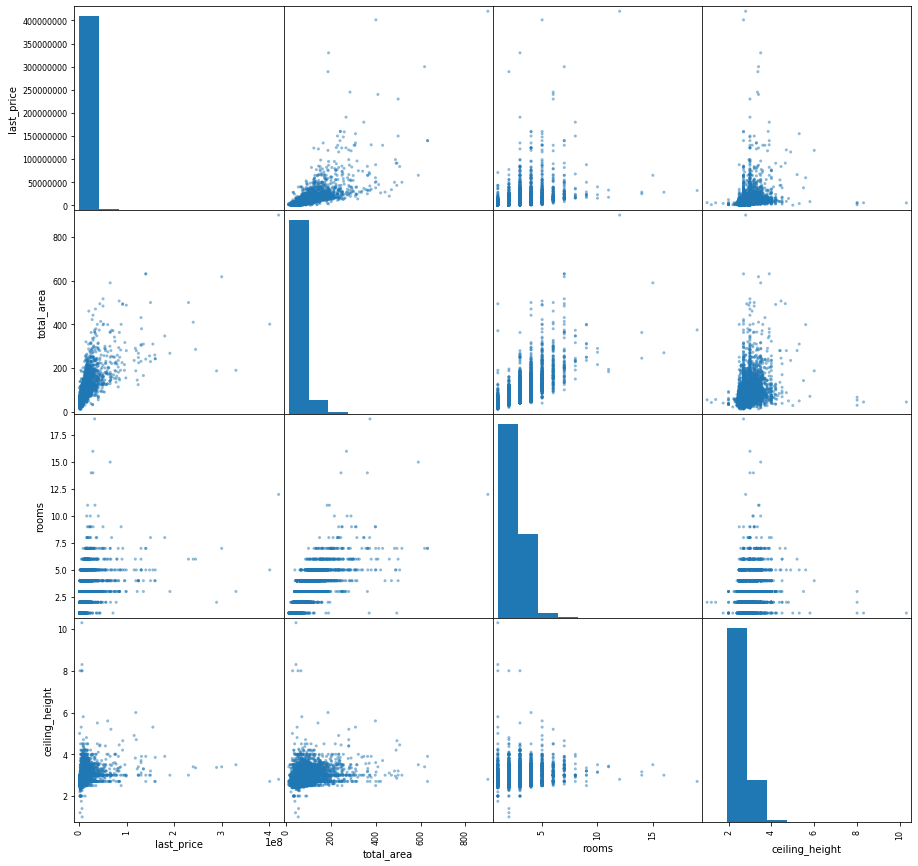

In [88]:
pd.plotting.scatter_matrix(kvartiri_spb[['last_price', 'total_area', 'rooms', 'ceiling_height']], figsize=(15, 15));

Здесь мы можем уже примерно взглянуть на закономерности и очевидные, такие как площадь от количества комнат, и ожидаемые, как рос цены от площади. Более детально зависимости рассмотрим дальше.

<a id="time"></a>
### Время продажи квартиры

In [89]:
kvartiri_spb['days_exposition'].describe()

count    20516.000000
mean       180.903734
std        219.733365
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

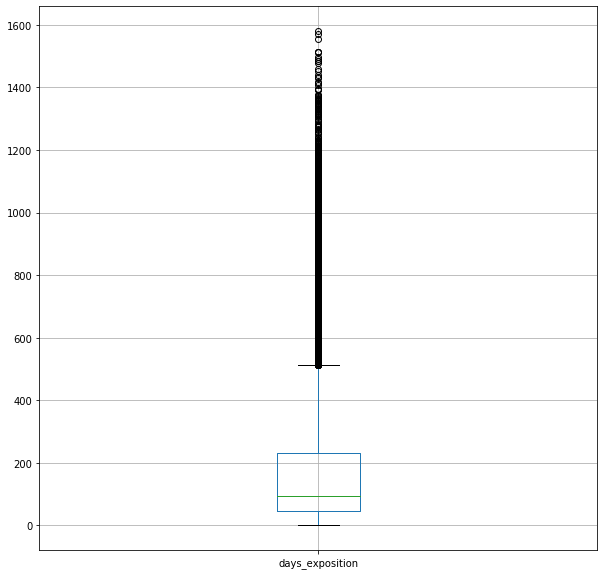

In [90]:
kvartiri_spb.boxplot(column='days_exposition', figsize=(10, 10));

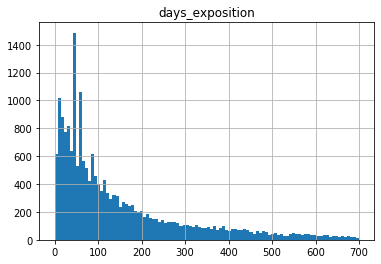

In [91]:
kvartiri_spb.hist(bins=100, range=(0, 700), column='days_exposition');

In [92]:
kvartiri_spb.sort_values(by='days_exposition', ascending=False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
18843,11,3500000,48.2,2014-12-15T00:00:00,2,2.50,5,27.4,2,True,False,False,7.7,3,деревня Новое Девяткино,NaN,NaN,0,NaN,0,NaN,1580.0,Новое Девяткино,0.568465,0.159751,72614,понедельник,декабрь,2014,другой
1109,1,34878556,95.8,2014-12-09T00:00:00,2,3.00,6,58.3,5,True,False,False,20.0,1,Санкт-Петербург,21860.0,318.0,2,160.0,3,569.0,1572.0,Санкт-Петербург,0.608559,0.208768,364076,вторник,декабрь,2014,другой
9553,11,10600000,80.0,2014-12-09T00:00:00,3,2.85,17,44.0,9,True,False,False,15.0,0,Санкт-Петербург,17101.0,17110.0,0,NaN,0,NaN,1553.0,Санкт-Петербург,0.550000,0.187500,132500,вторник,декабрь,2014,другой
1885,2,13300000,79.6,2014-12-09T00:00:00,2,3.00,8,42.7,7,True,False,False,18.0,0,Санкт-Петербург,39393.0,11096.0,1,537.0,0,NaN,1513.0,Санкт-Петербург,0.536432,0.226131,167085,вторник,декабрь,2014,другой
20969,18,13300000,133.0,2015-02-11T00:00:00,4,3.00,5,58.0,2,True,False,False,45.0,0,Санкт-Петербург,24653.0,5032.0,0,NaN,1,534.0,1512.0,Санкт-Петербург,0.436090,0.338346,100000,среда,февраль,2015,другой


Можно сказать, что продажа в среднем занимает 3 месяца, несмотря на то что минимальное значение равно 1, это не обязательно проадажа, а возможно просто снятие объявления. Основная же часть продается от 45 дней до 230, то есть все что продавалось быстрее чем за 1,5 месяца можно считать быстрой продажей, а вот более 7 месяцев уже затянувшейся. Более 500 дней, то есть 1,5 года - это уже совсем необычно долгие, так как там уже заканчиваются усы и начинаются выбросы :)

<a id="corr"></a>
## Зависимость цены квартиры

Посмотрим как влияют разные показатели на изменение стоиимости квартиры. Для этого посмотрим на корреляцию и диаграмму рассеяния 

<a id="corr_area"></a>
### Как влияет общая площадь на цену

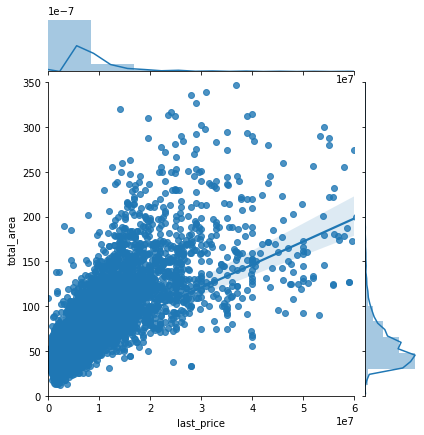

In [93]:
sns.jointplot(data=kvartiri_spb, x='last_price', y='total_area',
              xlim=(0, 0.6*10**8), ylim=(0, 350), kind='reg');

In [94]:
kvartiri_spb['last_price'].corr(kvartiri_spb['total_area'])

0.7026483740557239

Мы видим высокую зависимость стоимости от площади, что кажется логичным.

<a id="corr_rooms"></a>
### Как влияет комнаты на цену

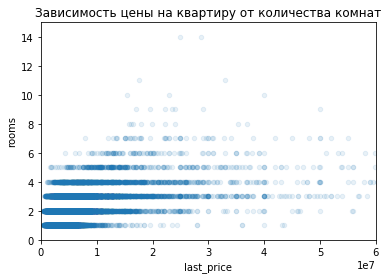

In [95]:
kvartiri_spb.plot(x='last_price', y='rooms', kind='scatter',
                 xlim=(0, 0.6*10**8), ylim=(0, 15), alpha=0.1);

plt.title('Зависимость цены на квартиру от количества комнат');

In [96]:
kvartiri_spb['last_price'].corr(kvartiri_spb['rooms'])

0.39433503683197324

Несмотря на низкий показатель корреляции, на графике мы все равно можем наблюдать смещение стоимости кваритры в сторону увеличения. Хотя это скорее связано соответствующим увеличеним площади, поэтому честнее было бы взять срез по небольшому разбросу площади.   
Посмотрим какой диапазон площади лучше взять, сделаем по нему срез и снова построим график

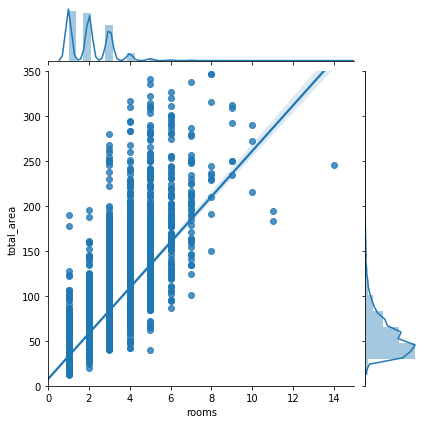

In [97]:
sns.jointplot(data=kvartiri_spb, x='rooms', y='total_area',
              xlim=(0, 15), ylim=(0, 350), kind='reg');

In [98]:
kvartiri_spb_area_cut = kvartiri_spb.query('90 < total_area < 110')

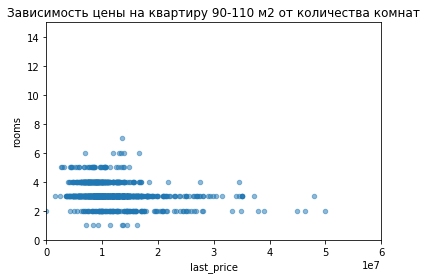

In [99]:
kvartiri_spb_area_cut.plot(x='last_price', y='rooms', kind='scatter',
                 xlim=(0, 0.6*10**8), ylim=(0, 15), alpha=0.5);

plt.title('Зависимость цены на квартиру 90-110 м2 от количества комнат');

Теперь, нивелировав влияние площади на цену, мы видим, что явной зависимости нет и цены на 2 и 3 комнатные квартиры чаще стоят дороже. 

<a id="corr_floor"></a>
### Как влияет этаж на цену

In [100]:
kvartiri_spb.groupby('whats_floor')['last_price'].agg(
    ['median', 'min', 'max', 'mean', 'count']).sort_values('median', ascending=False)

,median,min,max,mean,count
whats_floor,,,,,
другой,4850000,450000,330000000,6.674074e+06,17363
последний,4350000,12190,420000000,7.127957e+06,3417
первый,3900000,430000,135000000,4.803560e+06,2917


Зависимость от этажа тоже проглядывается - на первом дешевле всего, на последнем по медиане дешевле, чем на других,   
но есть дорогостоящие исключения (видимо квартиры с мансардами и прочим, что встречается иногда именно на последних этажах),  
которые повышают среднее значание.

<a id="corr_center"></a>
### Как влияет центр на цену

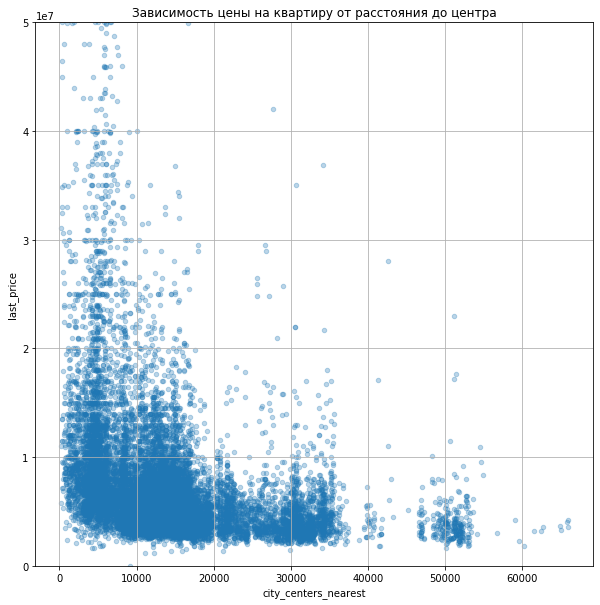

In [101]:
kvartiri_spb.plot(x='city_centers_nearest', y='last_price', kind='scatter',
                ylim=(0, 50*10**6), grid=True, figsize=(10, 10), alpha=0.3); # , 
plt.title('Зависимость цены на квартиру от расстояния до центра');

График наглядно показывает нам, как основная часть самых дорогих квартир сосредоточена в пределах до 10 км, потом количество квартир со стоимостью свыше 20 млн падает до 20 км и дальше встречаются крайне редко, сосредотачивая стоимость в диапозоне от 2 до 9 млн руб. Также видим, как мало недорогих (до 5 млн) объявлений в пределах 5 км от центра.

<a id="corr_day"></a>
### Как влияет день на цену

Посмотрим как на цены влияет день недели, месяц и год объявлений

In [102]:
kvartiri_spb.groupby('expositions_weekday')['last_price'].agg(
    ['median', 'mean', 'min', 'max', 'count']).sort_values('median', ascending=False)

,median,mean,min,max,count
expositions_weekday,,,,,
вторник,4730000,6.394233e+06,430000,289238400,4183
среда,4700000,6.625863e+06,12190,420000000,3973
понедельник,4650000,6.511613e+06,430000,300000000,3612
четверг,4650000,6.708663e+06,450000,159984000,4295
пятница,4585000,6.372131e+06,450000,190870000,4000
воскресенье,4550000,6.246180e+06,470000,130000000,1699
суббота,4550000,6.586094e+06,550000,401300000,1935


In [103]:
kvartiri_spb.groupby('expositions_month')['last_price'].agg(
    ['median', 'mean', 'min', 'max', 'count']).sort_values('median', ascending=False)

,median,mean,min,max,count
expositions_month,,,,,
апрель,4800000,6.737198e+06,430000,330000000,2379
декабрь,4700000,7.011731e+06,490000,420000000,1641
ноябрь,4700000,6.461363e+06,560000,160000000,2371
сентябрь,4700000,6.443564e+06,520000,131000000,1980
июль,4650000,6.644408e+06,440000,140000000,1694
март,4650000,6.359275e+06,12190,289238400,2587
февраль,4650000,6.468500e+06,450000,401300000,2640
январь,4600000,6.668233e+06,480000,180000000,1500
август,4570000,6.350233e+06,450000,159984000,1744


In [104]:
kvartiri_spb.groupby('expositions_year')['last_price'].agg(
    ['median', 'mean', 'min', 'max', 'count']).sort_values('median', ascending=False)

,median,mean,min,max,count
expositions_year,,,,,
2014,7700000,1.208714e+07,1200000,79339000,137
2015,5350000,8.572833e+06,650000,180000000,1191
2019,5050000,6.782388e+06,12190,289238400,2879
2016,4550000,6.827912e+06,490000,401300000,2783
2018,4550000,5.949904e+06,430000,330000000,8518
2017,4500000,6.493360e+06,450000,420000000,8189


Интересно, что по дням недели чаще всего и с наибольшей стоимостью выкладывают во вторник (видимо готовятся весь понедельник), а на выходных наоборот объявлений появлется меньше и в среднем они ниже в цене. По месяцам особой закономерности не вижу, нельзя даже выделить опредленное время года, только разве что под конец года (с октября по декабрь) продаются квартиры подороже. Но я бы это в расчет не брал.
По годам мы видим что 2014 выбился в топ, но это связано с малым количеством объявлений (137), что искажает показатели. Здесь интереснее отследить количество объявлений, которое сильно выросло с 2016 на 2017, удеражло свое количество и в 2019 скорее всего срез был сделан не в конце года, иначе на это стоит обратить внимание. Взглянем на дату последней публикации.

In [105]:
kvartiri_spb.sort_values('first_day_exposition', ascending=False).head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
17551,7,3200000,45.6,2019-05-03T00:00:00,2,2.6,5,30.9,5,False,False,False,5.6,1,Сосновый Бор,NaN,NaN,0,NaN,0,NaN,NaN,Сосновый Бор,0.677632,0.122807,70175,пятница,май,2019,последний
17872,3,4650000,34.8,2019-05-03T00:00:00,1,2.5,9,13.9,1,True,False,False,11.2,0,Санкт-Петербург,12384.0,12296.0,0,NaN,1,396.0,NaN,Санкт-Петербург,0.399425,0.321839,133620,пятница,май,2019,первый


Все ок, как раз срез за первые 4 месяца равен примерно трети по количеству объявлений. Плохо только, что их количество не растет, как в 2017 году :)

<a id="top"></a>
## ТОП-10

Посмотрим на ТОП-10 городов по кол-ву объявлений

In [106]:
kvartiri_spb.groupby('locality_simple_name').count().sort_values('total_images', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor
locality_simple_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Санкт-Петербург,15748,15748,15748,15748,15748,15748,15748,15748,15748,15748,15748,15748,15748,15748,15719,15663,15687,15748,7297,15748,7997,13665,14606,14365,15748,15748,15748,15748,15748
Мурино,590,590,590,590,590,590,590,590,590,590,590,590,590,590,590,2,2,590,0,590,2,551,524,480,590,590,590,590,590
Кудрово,472,472,472,472,472,472,472,472,472,472,472,472,472,472,472,0,0,472,0,472,0,441,424,389,472,472,472,472,472
Шушары,440,440,440,440,440,440,440,440,440,440,440,440,440,440,440,436,436,440,0,440,152,408,404,398,440,440,440,440,440
Всеволожск,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,0,0,398,0,398,0,339,371,357,398,398,398,398,398
Пушкин,369,369,369,369,369,369,369,369,369,369,369,369,369,369,369,369,368,369,212,369,177,307,345,338,369,369,369,369,369
Колпино,338,338,338,338,338,338,338,338,338,338,338,338,338,338,338,337,337,338,133,338,190,308,328,322,338,338,338,338,338
Парголово,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,10,327,56,302,301,289,327,327,327,327,327
Гатчина,307,307,307,307,307,307,307,307,307,307,307,307,307,307,307,0,0,307,0,307,0,268,292,294,307,307,307,307,307


In [107]:
top_10_ad_sum_city = kvartiri_spb.groupby('locality_simple_name').count().sort_values('total_images', ascending=False).head(10).index.tolist()

In [108]:
top_10_ad_sum_city

['Санкт-Петербург',
 'Мурино',
 'Кудрово',
 'Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'Парголово',
 'Гатчина',
 'Выборг']

In [109]:
kvartiri_spb.groupby('locality_simple_name')['m2_price'].agg(
    ['median', 'mean', 'min', 'max', 'count']).sort_values('count', ascending=False).head(10)

,median,mean,min,max,count
locality_simple_name,,,,,
Санкт-Петербург,104761.0,114692.728537,111,1736842,15748
Мурино,86175.0,86087.055932,50000,138580,590
Кудрово,95675.0,95324.476695,54160,160401,472
Шушары,76876.0,78676.904545,47700,147826,440
Всеволожск,65789.0,68654.007538,31400,640422,398
Пушкин,100000.0,103125.373984,59836,256521,369
Колпино,74723.5,75424.150888,47957,125000,338
Парголово,91642.0,90175.489297,39205,138522,327
Гатчина,67796.0,68745.693811,10507,146315,307


Мы видим, что Питер в лидерах по стоимости за квадратный метр, но Пушкин не сильно отстает. Ни разу там не был, стоит как-нибудь заглянуть. На третьем месте у нас Кудрово.

<a id="center"></a>
## Центр города

<a id="km"></a>
### Определим границы для центра города

In [110]:
kvartiri_spb['city_centers_nearest_km'] = kvartiri_spb['city_centers_nearest'] / 1000
#kvartiri_spb[kvartiri_spb['city_centers_nearest_km'] == 0]
#kvartiri_spb['city_centers_nearest_km'] = kvartiri_spb['city_centers_nearest_km'].fillna(0)
# kvartiri_spb['city_centers_nearest_km'] = kvartiri_spb['city_centers_nearest_km'].astype('int')
# kvartiri_spb['city_centers_nearest_km'] = kvartiri_spb['city_centers_nearest_km'
#                                                       ].where(kvartiri_spb['city_centers_nearest_km'] != 0, np.NaN)
kvartiri_spb['city_centers_nearest_km'] = kvartiri_spb.city_centers_nearest_km.round().astype('Int64')
kvartiri_spb

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_simple_name,living_area_part,kitchen_area_part,m2_price,expositions_weekday,expositions_month,expositions_year,whats_floor,city_centers_nearest_km
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16,51.000000,8,True,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,0.472222,0.231481,120370,четверг,март,2019,другой,16
1,7,3350000,40.40,2018-12-04T00:00:00,1,2.70,11,18.600000,1,True,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,0.460396,0.272277,82920,вторник,декабрь,2018,первый,19
2,10,5196000,56.00,2015-08-20T00:00:00,2,2.70,5,34.300000,4,True,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,0.612500,0.148214,92785,четверг,август,2015,другой,14
3,0,64900000,159.00,2015-07-24T00:00:00,3,2.70,14,100.435000,9,True,False,False,20.442857,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург,NaN,NaN,408176,пятница,июль,2015,другой,7
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.000000,13,True,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,0.320000,0.410000,100000,вторник,июнь,2018,другой,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21T00:00:00,3,3.70,5,73.300000,3,True,False,False,13.830000,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN,Санкт-Петербург,0.547792,0.103356,72490,вторник,март,2017,другой,4
23695,14,3100000,59.00,2018-01-15T00:00:00,3,2.60,5,38.000000,4,True,False,False,8.500000,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0,Тосно,0.644068,0.144068,52542,понедельник,январь,2018,другой,NaN
23696,18,2500000,56.70,2018-02-11T00:00:00,2,2.90,3,29.700000,1,True,False,False,9.132958,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN,Рождествено,0.523810,NaN,44091,воскресенье,февраль,2018,первый,NaN
23697,13,11475000,76.75,2017-03-28T00:00:00,2,3.00,17,44.899452,12,True,False,False,23.300000,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602.0,Санкт-Петербург,NaN,0.303583,149511,вторник,март,2017,другой,10


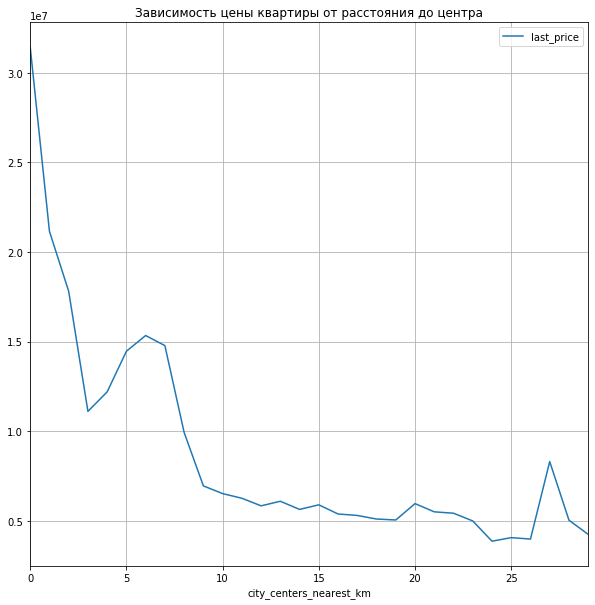

In [111]:
kvartiri_spb_for_plot1 = kvartiri_spb.query('locality_simple_name == "Санкт-Петербург"'
                  ).groupby('city_centers_nearest_km'
                           )['last_price'].agg('mean'
                                            ).reset_index()
kvartiri_spb_for_plot1.plot(x='city_centers_nearest_km', y='last_price', grid=True, figsize=(10, 10));
plt.title('Зависимость цены квартиры от расстояния до центра');

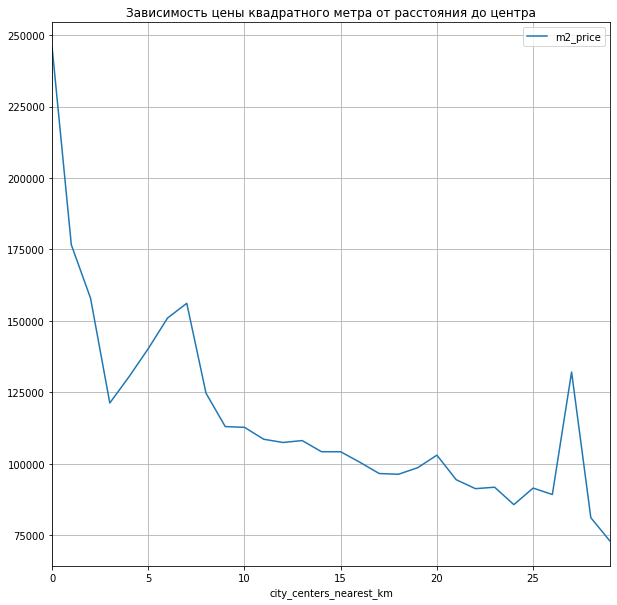

In [112]:
kvartiri_spb_for_plot2 = kvartiri_spb.query('locality_simple_name == "Санкт-Петербург"'
                  ).groupby('city_centers_nearest_km'
                           )['m2_price'].agg('mean'
                                            ).reset_index()
kvartiri_spb_for_plot2.plot(x='city_centers_nearest_km', y='m2_price', grid=True, figsize=(10, 10));
plt.title('Зависимость цены квадратного метра от расстояния до центра');

В обоих графиках зависимости общей стоимости и цены кв метра мы видим перелом в районе 5-6 км, значит где-то недалеко от него и кончается центр города... Примем это число за 8 км.

<a id="an"></a>
### Анализ центра города

In [113]:
kvartiri_spb_center = kvartiri_spb.query('city_centers_nearest_km < 8')

In [114]:
kvartiri_spb_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,3540.000000,3.540000e+03,3540.000000,3540.000000
mean,93.044141,1.466077e+07,2.838418,3.000977
std,59.156181,2.076169e+07,1.438341,0.343854
min,12.000000,1.600000e+06,1.000000,2.400000
25%,57.000000,6.650000e+06,2.000000,2.700000
50%,78.700000,9.200000e+06,3.000000,3.000000
75%,110.000000,1.450000e+07,3.000000,3.150000
max,631.200000,4.013000e+08,19.000000,6.000000


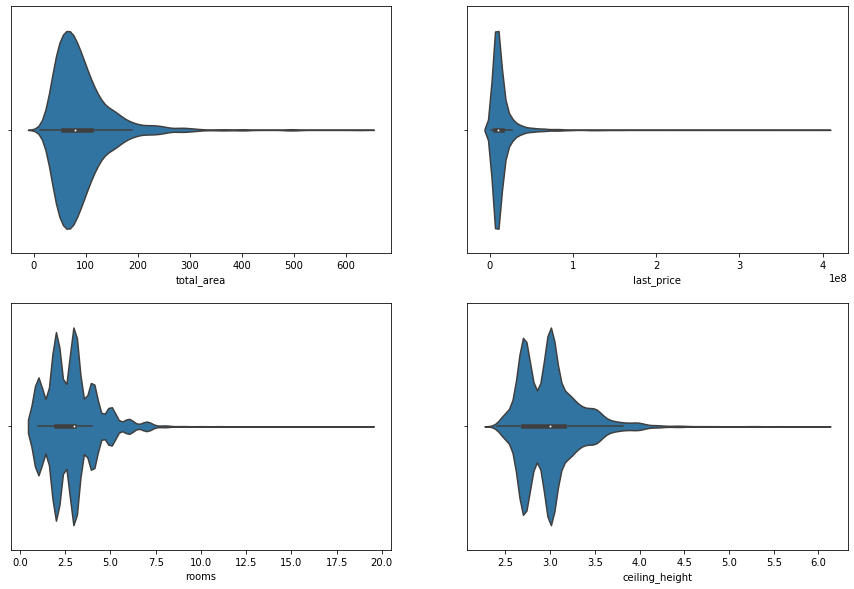

In [115]:
f, ax = plt.subplots(2, 2, figsize=(15, 10))
#sns.set_theme(style="whitegrid")
sns.violinplot(x=kvartiri_spb_center['total_area'], ax=ax[0][0]);
sns.violinplot(x=kvartiri_spb_center['last_price'], ax=ax[0][1]);
sns.violinplot(x=kvartiri_spb_center['rooms'], ax=ax[1][0]);
sns.violinplot(x=kvartiri_spb_center['ceiling_height'], ax=ax[1][1]);

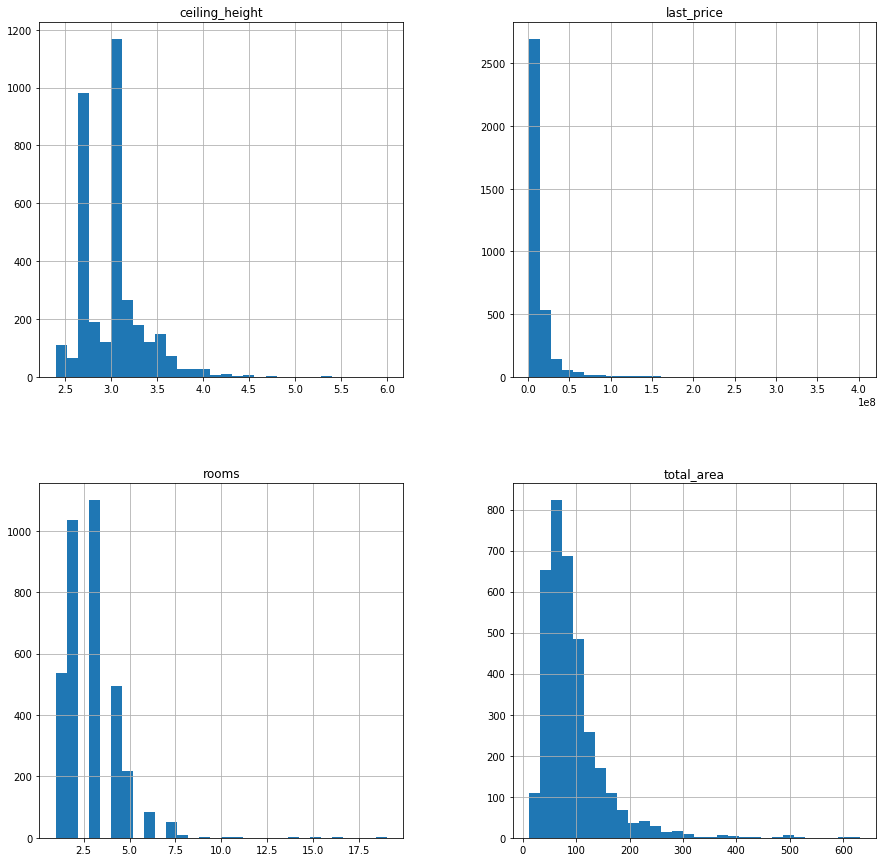

In [116]:
kvartiri_spb_center.hist(bins=30, column=['total_area', 'last_price', 'rooms', 'ceiling_height'], figsize=(15, 15));

Что можно сказать о центре? Из всех объявлений у нас под наш критерий цетра попало всего 3,5 тыс объявлений, не так уж много.
По показателем можно сказать следующее:
- Основная часть квартир имеет площади от 60 до 110 м2, что на удивление просторнее средних показателей по всем объявлениям.
- Цены ожидаемо выше и находятся в среднем в диапазоне от 6,6 млн до 14,5 млн руб, однако имеют сильный хвост, тянущий до заоблочных цен в размере 400 млн.
- В центре больше трехкомнатных квартир, и меньше однокомнатных, что сильно отличается от общей выборки
- И по высоте потолков тоже чаще встречаются 3ех метровые квартиры и реже стандартные 2,7 м.

В общем наблюдаем тенденцию, что в центре квартиры просторнее, с большим количством комнат, приемущественно 3ех комнтаные, с высотой потолков чаще в 3 м, что тоже выше чем в среднем по всем объявлением и соответсвенно гораздо дороже (практически в два раза, если быть точнее).

In [117]:
sns.set(rc={'figure.figsize':(12, 12)}, style="whitegrid")

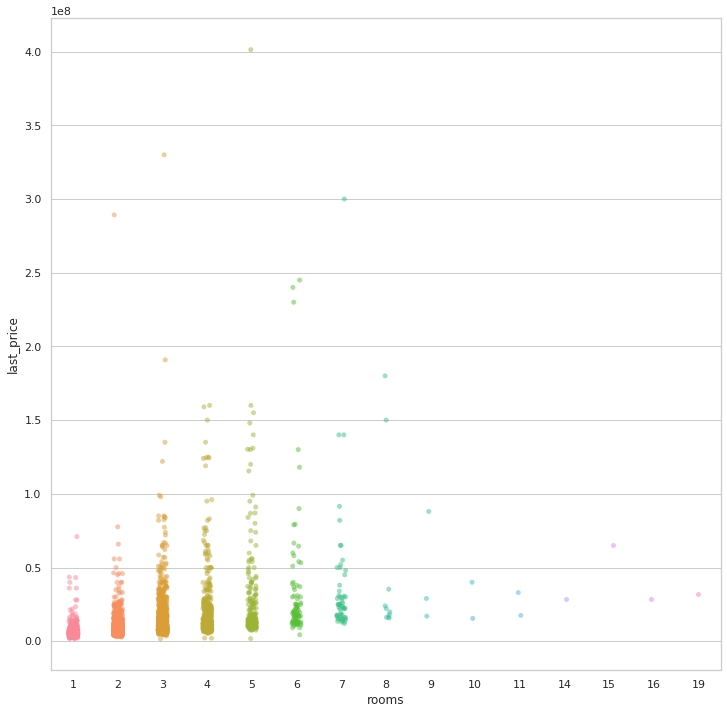

In [118]:
sns.stripplot(data=kvartiri_spb_center,
              x='rooms',
              y='last_price',
              dodge=True,
              alpha=.5,
             hue=None);

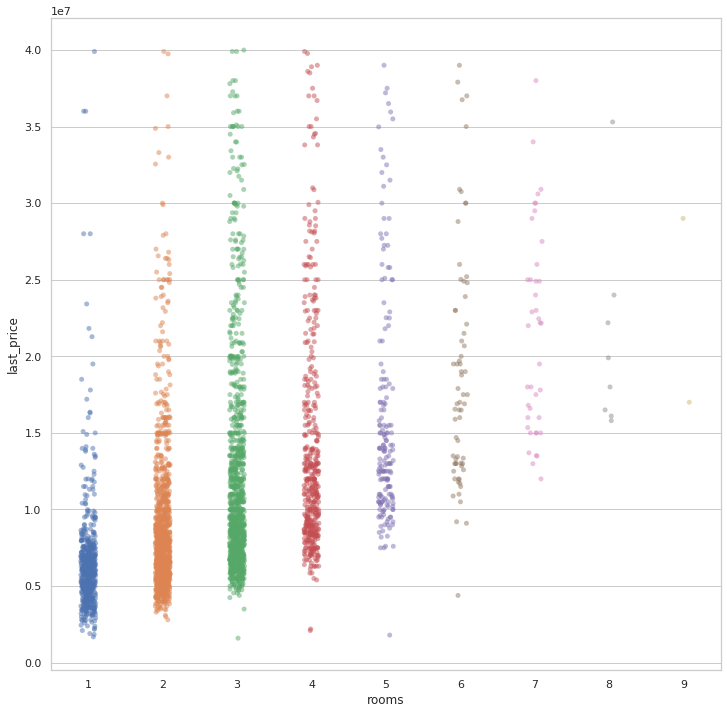

In [119]:
sns.stripplot(data=kvartiri_spb_center.query('rooms < 10 & last_price < 40*10**6'),
              x='rooms',
              y='last_price',
              dodge=True,
              alpha=.5,
             hue=None);

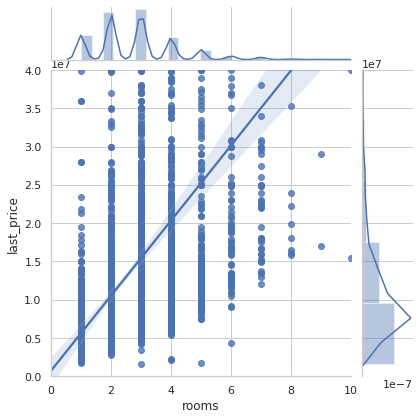

In [120]:
sns.jointplot(data=kvartiri_spb_center, x='rooms', y='last_price',
              xlim=(0, 10),
              ylim=(0, 40*10**6),
              kind='reg');

In [121]:
kvartiri_spb_center['last_price'].corr(kvartiri_spb_center['rooms'])

0.3398338315414706

В центре та же тендеция роста цены с количеством комнат, которую мы увязали с ростом общей площади квартир и на что лишний раз указывает низкая корреляция (хотя наверное это более связано с дискретностью показателя по комнатам).

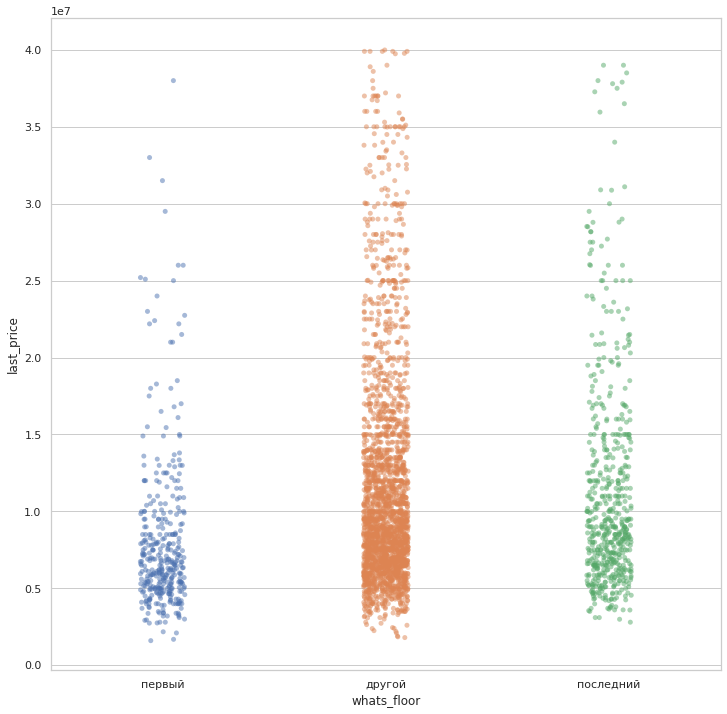

In [122]:
sns.stripplot(data=kvartiri_spb_center.query('last_price < 40*10**6'),
              x='whats_floor',
              y='last_price',
              dodge=True,
              alpha=.5,
             hue=None);

Зависимость цены от этажа показывает нам ту же тенденцию снижения цен для первых. Для последних же здесь мне кажется уже нет особых отличий от других.

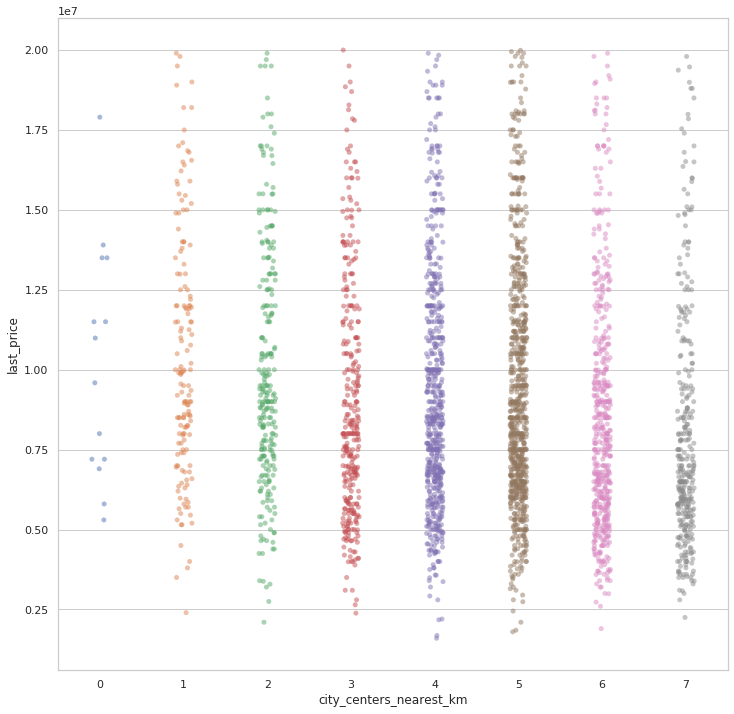

In [123]:
sns.stripplot(data=kvartiri_spb_center.query('last_price < 20*10**6'),
              x='city_centers_nearest_km',
              y='last_price',
              dodge=True,
              alpha=.5,
             hue=None);

В центре уже не наблюадется такой четкой зависимости от удаленности, потому что это и так центр. Можно только заметить, что определенный пласт дешевых квартир практически отсутствует в пределах первых 3 км.

Зависимость от времени публикации

In [124]:
kvartiri_spb_center.groupby('expositions_weekday')['last_price'].agg(
    ['median', 'mean', 'min', 'max', 'count']).sort_values('median', ascending=False)

,median,mean,min,max,count
expositions_weekday,,,,,
воскресенье,9400000,1.561465e+07,2100000,130000000,193
понедельник,9393000,1.465443e+07,1686000,300000000,538
среда,9350000,1.431014e+07,2400000,330000000,615
четверг,9300000,1.457245e+07,1800000,159984000,724
вторник,9175000,1.412085e+07,1600000,289238400,604
пятница,9000000,1.463669e+07,2100000,190870000,596
суббота,8594500,1.628805e+07,2750000,401300000,270


А здесь вторник соскочил и воскресенье с понедельником на первом месте. Однозначно пятница и суббота проигрывают - видимо шаббат всё-таки сильнее влияет на центр города :)

In [125]:
kvartiri_spb_center.groupby('expositions_month')['last_price'].agg(
    ['median', 'mean', 'min', 'max', 'count']).sort_values('median', ascending=False)

,median,mean,min,max,count
expositions_month,,,,,
январь,9900000,1.600120e+07,2800000,180000000,217
сентябрь,9562880,1.325377e+07,2800000,131000000,302
ноябрь,9500000,1.414312e+07,2730000,160000000,354
февраль,9500000,1.502554e+07,1800000,401300000,386
март,9400000,1.450720e+07,1850000,289238400,374
июль,9200000,1.517649e+07,1600000,140000000,279
апрель,9000000,1.628281e+07,3000000,330000000,335
август,8970000,1.387574e+07,1900000,159984000,261
июнь,8900000,1.433362e+07,2200000,124480000,291


В этот раз декабрь заменил январь и под конец года не прослеживается уже четкое увеличение количества и стоимости объявлений, однако большая часть осени у нас опять в топе.

In [126]:
kvartiri_spb_center.groupby('expositions_year')['last_price'].agg(
    ['median', 'mean', 'min', 'max', 'count']).sort_values('median', ascending=False)

,median,mean,min,max,count
expositions_year,,,,,
2014,19445000,2.540346e+07,5350000,79339000,28
2015,10225000,1.708568e+07,3299000,180000000,324
2019,9488000,1.536379e+07,1850000,289238400,382
2016,9480000,1.558726e+07,1800000,401300000,502
2017,9000000,1.469797e+07,2100000,300000000,1260
2018,8850000,1.287247e+07,1600000,330000000,1044


По годам можно заметить общий рост количества объявлений, но при этом все же спад медианной стоимости, хотя довольно грубое и неоднозначное приближение...

<a id="center_conclusion"></a>
### Вывод по центру

Есть свои отличия от общих показателей. Квартиры просторнее и дороже, зависимости от основных факторов тоже другая.

<a id="conclusion"></a>
## Шаг 5. Общий вывод

Рассмотрев все показатели, мы выявили, что в общем у нас в Санкт-Петербурге и близлежащих городах преобладают объявления 1 и 2ух комнатных квартир с высотой потолка 2,7 м, общей площадью около 50 кв м, стоимость на которые колеблится чаще в пределах от 3,5 - 7 млн руб. В центре (который мы определили радиусом в 8 км) цены гораздо выше и в среднем составляют от 6,6 до 14,5 млн руб, что в два раза выше средних показателей по всем объявлениям. Однако и сами квартиры чаще просторнее по площаде и высоте потолков и преобладают уже 3ех комнатные квартиры. 
Заметили снижение стоимости квартир на первом этаже, также разную зависимость стоимости и количества объявлений в общей выборке и выборке по центру. Если в общей преобладал вторник а выходные проигрывали, то в центре чаще и дороже объявления появлялись в воскресенье и понедельник. По годам общая тенденция к росту количества объявлений и снижению средней стоимости, видимо, из-за появления большего количества недорогих квартир. По месяцам можно было бы выделить осень как период роста количества и средней цены объявлений. Закономерности стоимости от количества комнат не выявлено. А с приближением к центру логично стоимость квартир увеличивается.
Сама продажа занимает чаще от 1,5 до 7 месяцев (около 3 в среднем).
По количеству объявлений лидирует Санкт-Петербург с недосягаемым отрывом, но также в топ-10 вошли Мурино, Кудрово, Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина, Выборг.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод

THE END